In [1]:
from dask.distributed import Client
import numpy as np
from scipy.interpolate import griddata  
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import intake
import dask
import multiprocessing
import xarray as xr
import pandas as pd
import sys
import glob
ncpu = multiprocessing.cpu_count()
threads = 6
nworker = ncpu//threads
print(f'Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}')

Number of CPUs: 256, number of threads: 6, number of workers: 42


In [2]:
client = Client(processes=True)#, threads_per_worker=threads, n_workers=nworker)#, memory_limit='32GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 9
Total threads: 54,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34689,Workers: 9
Dashboard: http://127.0.0.1:8787/status,Total threads: 54
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:36557,Total threads: 6
Dashboard: http://127.0.0.1:39939/status,Memory: 11.11 GiB
Nanny: tcp://127.0.0.1:43553,


# All datasets

In [6]:
root_path='/work/bd1022/from_Mistral/bd1022/b381258/ERA5/'#'/mnt/lustre02/work/bd1022/b381258/ERA5/'
sub_dir=''
variable=129
infiles = f'{root_path}{sub_dir}E5pl00_1D_*{variable}.nc'
print(infiles)
sorted(glob.glob(infiles))

/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_*129.nc


['/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-01_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-02_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-03_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-04_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-05_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-06_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-07_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-08_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-09_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-10_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-11_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1979-12_129.nc',
 '/work/bd1022/from_Mistral/bd1022/b381258/ERA5/E5pl00_1D_1980-01_129.nc',
 '/work/bd1022/from_Mistr

In [ ]:
root_path='/mnt/lustre02/work/bd1022/b381258/ERA5/'
sub_dir=''
variable=129
infiles = f'{root_path}{sub_dir}E5pl00_1D_*{variable}.nc'
print(infiles)

In [4]:
ds = xr.open_mfdataset(
    infiles, 
    parallel = True,
    concat_dim = 'time',
    combine='nested',
    data_vars='minimal', coords='minimal', 
    #chunks = {"time": 10}
)#.chunk({'time': 30})
ds['time'] = pd.date_range('1979-01-01', '2015-12-31', freq = '1D')
ds

<xarray.Dataset>
Dimensions:  (time: 13514, lon: 1280, lat: 640, plev: 3)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2015-12-31
  * lon      (lon) float64 0.0 0.2812 0.5625 0.8438 ... 358.9 359.2 359.4 359.7
  * lat      (lat) float64 89.78 89.51 89.23 88.95 ... -89.23 -89.51 -89.78
  * plev     (plev) float64 1e+03 5e+03 1e+04
Data variables:
    Z        (time, plev, lat, lon) float32 dask.array<chunksize=(31, 3, 640, 1280), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    institution:  European Centre for Medium-Range Weather Forecasts
    Conventions:  CF-1.6
    history:      Mon May 09 18:16:05 2022: cdo -sellevel,1000,5000,10000 /mn...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [5]:
A = 6374.0e3       # Earth radius
DEGRAD = np.pi/180. # conversion of degrees to radians
RADDEG = 180./np.pi # conversion of radians to degrees 

#optimized
def sph_to_car(field, lons, lats, xypoints,resolution):
    nlons = len(lons)
    nlats = len(lats)
    xyvals = []
    for ilon in range(nlons): # -1s needed?
        for ilat in range(nlats):
            xyvals.append(field[ilat,ilon])

    if resolution == 'full':       
        cart_x_points = -1.+np.arange(nlons)/(0.5*nlons)             
        cart_y_points = -1.+np.arange(nlons)/(0.5*nlons)
    elif resolution == 'low':
        cart_x_points = -1.+np.arange(50)/(0.5*50)
        cart_y_points = -1.+np.arange(50)/(0.5*50)
    else:
        raise ValueError()
    
    cart_gridx, cart_gridy = np.meshgrid(cart_x_points,cart_y_points)

    field_cart = griddata(xypoints, np.array(xyvals), (cart_gridx,cart_gridy), \
                        method='linear')  # Might want to change to cubic etc?
                              
    return field_cart, cart_x_points, cart_y_points  
#the same
def isolate_vortex(field_cart, edge, field_type='GPH'):
    """
    Replace vortex into region (outside) equal to field on vortex edge, and 
    region (inside) with values of vortex. 
    For GPH vortex is less than surrounding, for PV it is greater. 
    """
    if field_type == 'GPH':
        field_cart[np.where(field_cart > edge)] = edge
        field_cart[np.isnan(field_cart)] = edge # set NaN regions to edge 
    elif field_type == 'PV':
        field_cart[np.where(field_cart < edge)] = edge
        field_cart[np.isnan(field_cart)] = edge # set NaN regions to edge
    else:
        raise ValueError() # maybe want more specific error type

    return field_cart

def moment_integrate2(vtx_field, x, y,edge):
    """
    Performs moment diagnostic calculations on cartesian field
    """

    # x and y are cartesian gridpoints; vtx_field is cartesian field
    # edge is value on vortex edge 

    box_length = 2*A/len(x)
    box_area = box_length**2

    # Set up moment diagnostics
    M00 = 0
    M10 = 0
    M01 = 0
    Marea = 0
    # Integrate over vortex
          
    M00 = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**0)*(y[np.newaxis,:]**0))
    M10 = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**1)*(y[np.newaxis,:]**0))
    M01 = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**0)*(y[np.newaxis,:]**1))
    Marea = np.sum(np.abs(vtx_field-edge)*(x[:,np.newaxis]**0)*(y[np.newaxis,:]**0)*box_area)
            
    # Calculate centroid 
    centx = M10/M00
    centy = M01/M00

    # Convert back to polar coordinates 
    R = centx**2 + centy**2
    latcent = np.arcsin((1-R)/(1+R))*RADDEG
    loncent = np.arctan(centx/centy)*RADDEG
    
    # Set up relative moment diagnostics 
    J11 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**1)*((y[np.newaxis,:]-centy)**1))
    J20 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**2)*((y[np.newaxis,:]-centy)**0))
    J02 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**0)*((y[np.newaxis,:]-centy)**2))
    J22 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**2)*((y[np.newaxis,:]-centy)**2))
    J40 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**4)*((y[np.newaxis,:]-centy)**0))
    J04 = np.sum(np.abs(vtx_field-edge)*((x[:,np.newaxis]-centx)**0)*((y[np.newaxis,:]-centy)**4))  

    
      # Calculate angle between x-axis and major axis of ellipse                  
    angle = 0.5*np.arctan((2*J11)/(J20-J02))*RADDEG
    
    # Calculate aspect ratio
    ar = np.sqrt(abs(( (J20+J02) + np.sqrt(4*(J11**2)+(J20-J02)**2) ) / \
                               ( (J20+J02) - np.sqrt(4*(J11**2)+(J20-J02)**2) ))) 
    
    objective_area = Marea/edge 
    
    # Calculate excess kurtosis 
    kurtosis = M00 * (J40+2*J22+J04)/((J20+J02)**2) \
                         - (2./3.)*( (3*(ar**4)+2*(ar**2)+3) / (((ar**2)+1)**2) ) 
    
    return angle, ar, objective_area, kurtosis, latcent, loncent 

def calc_moments(field, lats, lons, xypoints, hemisphere='NH', field_type='GPH', \
                 edge=3.02e4, resolution='full'):
    field_cart, x, y = sph_to_car(field,lons,lats,xypoints,resolution)
    field_vtx = isolate_vortex(field_cart, edge, field_type)
   
    #angle, aspect_ratio, objective_area, kurtosis, latcent, loncent = moment_integrate2(field_vtx, x, y,edge)
        
    #return {'aspect_ratio':aspect_ratio, 'centroid_latitude': latcent, 'centroid'}
    values = moment_integrate2(field_vtx, x, y, edge)
    return values
                 
def calc_xypoints(lons, lats):
    DEGRAD = np.pi/180.
    lons = lons * DEGRAD
    lats = lats * DEGRAD
    x = (np.cos(lons[:,np.newaxis])*np.cos(lats))/ (1. + np.sin(lats[np.newaxis,:]))               
    y = (np.sin(lons[:,np.newaxis])*np.cos(lats[np.newaxis,:]))/(1. + np.sin(lats[np.newaxis,:]))
    nlon_nlat = lons.shape[0]*lats.shape[0]
    xypoints = np.stack([x.reshape(nlon_nlat),y.reshape(nlon_nlat)], axis = 1)
    return xypoints
                 
def moments_fce(arr, edge=3.02e4):
    moments = calc_moments(arr, lats, lons, xypoints, 'NH','GPH', edge)
    return np.array(moments) #np.array([moments['aspect_ratio'], moments['centroid_latitude']])


In [10]:
winter_month_ls = [11,12,1,2,3,4]

ds_sel = ds.sel(
    plev = 1000,
    lat = slice(None,20), 
    time = np.isin(
        ds.time.dt.month, 
        winter_month_ls
    )
)['Z'].sel(time = slice(None,'2014'))/9.81##.persist()
ds_sel

<xarray.DataArray 'Z' (time: 6525, lat: 249, lon: 1280)>
dask.array<truediv, shape=(6525, 249, 1280), dtype=float32, chunksize=(31, 249, 1280), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2014-12-31
  * lon      (lon) float64 0.0 0.2812 0.5625 0.8438 ... 358.9 359.2 359.4 359.7
  * lat      (lat) float64 89.78 89.51 89.23 88.95 ... 20.94 20.66 20.37 20.09
    plev     float64 1e+03

In [15]:
ds_sel.to_netcdf('/work/bd1022/b381258/CMIP6/gh10/Z_ERA5_climatology_1979-2014.nc')

## Interim ouput

In [8]:
lons = ds_sel.lon.values
lats = ds_sel.lat.values
xypoints = calc_xypoints(lons,lats)

In [9]:
temp = ds_sel.sel(lat = 60, method = 'nearest').mean(['lon','time']).compute()
temp#.load() .sel(time = np.isin(reshaped_sel.time.dt.month, winter_month_ls))

<xarray.DataArray 'Z' ()>
array(30243.232, dtype=float32)
Coordinates:
    lat      float64 60.0
    plev     float64 1e+03

In [11]:
moments_xr = xr.apply_ufunc(moments_fce, ds_sel, temp, \
                        input_core_dims=[['lat', 'lon'], []], \
                        output_core_dims=[['vars']], \
                        output_dtypes = [float], vectorize=True, \
                        dask = 'parallelized',\
                        output_sizes = dict(vars = 6)).compute()


moments_xr['vars'] = ['angle', 'aspect_ratio', 'objective_area', 'kurtosis', 'centroid_latitude', 'centroid_longitude']#.reset_coords()
moments_ds = moments_xr.to_dataset(dim = 'vars') #.reset_coords('vars')
moments_ds

/tmp/ipykernel_2708081/4227647566.py:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  moments_xr = xr.apply_ufunc(moments_fce, ds_sel, temp, \
/tmp/ipykernel_2708081/2588822085.py:71: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_2708081/2588822085.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_2708081/2588822085.py:71: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_2708081/2588822085.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_2708081/2588822085.py:71: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_2708081/2588822085.py:72: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_2708081/2588822085.py:71: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_2708081/2588822085.py:72: Runt

<xarray.Dataset>
Dimensions:             (time: 6525)
Coordinates:
  * time                (time) datetime64[ns] 1979-01-01 ... 2014-12-31
    plev                float64 1e+03
Data variables:
    angle               (time) float64 -0.8142 -28.5 -41.18 ... 29.95 22.41
    aspect_ratio        (time) float64 1.046 1.059 1.131 ... 1.172 1.497 2.009
    objective_area      (time) float64 5.2e+11 5.051e+11 ... 3.277e+11 3.167e+11
    kurtosis            (time) float64 0.2488 0.2303 0.2304 ... 0.2218 0.1428
    centroid_latitude   (time) float64 80.92 80.58 80.73 ... 76.82 77.41 77.24
    centroid_longitude  (time) float64 -19.52 -24.54 -24.14 ... -18.56 -39.82

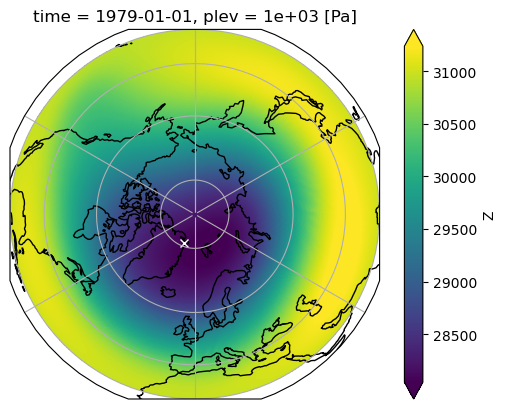

In [14]:
p = ds_sel[0].plot(transform=ccrs.PlateCarree(), robust = True,\
                        subplot_kws={'projection': ccrs.Orthographic(0, 90)})
ax = p.axes
ax.coastlines()
#ax.add_geometries(list(shape), ccrs.Orthographic(0, 90), 
#                 facecolor=None, edgecolor='k')#, **kwargs alpha=0.8
ax.gridlines()
ax.plot(
    moments_ds['centroid_longitude'][0], 
    moments_ds['centroid_latitude'][0], 
    'wx',
    transform=ccrs.PlateCarree()
)

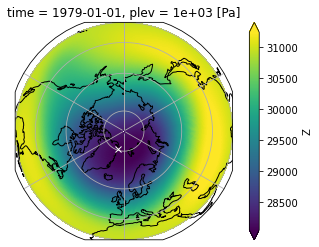

In [47]:
p = ds_sel[0,0].plot(transform=ccrs.PlateCarree(), robust = True,\
                        subplot_kws={'projection': ccrs.Orthographic(0, 90)})
ax = p.axes
ax.coastlines()
#ax.add_geometries(list(shape), ccrs.Orthographic(0, 90), 
#                 facecolor=None, edgecolor='k')#, **kwargs alpha=0.8
ax.gridlines()
ax.plot(
    moments_ds['centroid_longitude'][0,0], 
    moments_ds['centroid_latitude'][0,0], 
    'wx',
    transform=ccrs.PlateCarree()
)

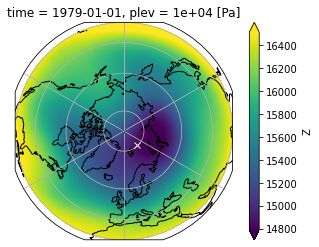

In [46]:
p = ds_sel[0,1].plot(transform=ccrs.PlateCarree(), robust = True,\
                        subplot_kws={'projection': ccrs.Orthographic(0, 90)})
ax = p.axes
ax.coastlines()
#ax.add_geometries(list(shape), ccrs.Orthographic(0, 90), 
#                 facecolor=None, edgecolor='k')#, **kwargs alpha=0.8
ax.gridlines()
ax.plot(
    moments_ds['centroid_longitude'][0,1], 
    moments_ds['centroid_latitude'][0,1], 
    'wx',
    transform=ccrs.PlateCarree()
)

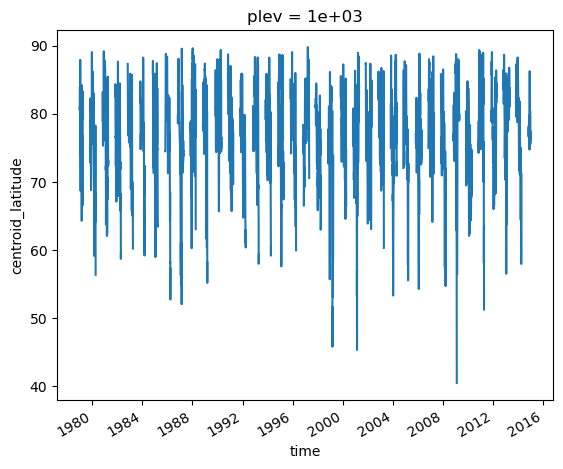

In [16]:
moments_ds['centroid_latitude'].plot.line()

In [17]:
moments_ds.nbytes/1e6

0.365408

In [18]:
user = 'b381258'
outpath=f'/work/bd1022/{user}/'
output = f'{outpath}ERA5/ERA5_moments@10hPa_NHonly_includingApril.nc'
print(output)
moments_ds.to_netcdf(output)

/work/bd1022/b381258/ERA5/ERA5_moments@10hPa_NHonly_includingApril.nc
